In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

experiment_names = ['owl_exp_pure',
                    'owl_exp_mixed',
                    'strike_exp_pure',
                    'strike_exp_mixed',
                    'energy_gain_pure',
                    'energy_gain_mixed',
                    ]
totals = []
point_class_dfs = []
parameters = []
for label in experiment_names:
    file_path_pcs = '/home/mremington/Documents/krattle_analysis/krattle_analysis/per_cycle_analysis/data/{}_point_classifacation.csv'.format(label)
    temp_exp_pc = pd.read_csv(file_path_pcs,header = 0, index_col=None)
    point_class_dfs.append(temp_exp_pc)
    for i in range(1,7):
        file_path_totals = '/home/mremington/Documents/uumarrty_exps/{}/exp{}/Data/totals.csv'.format(label,i)
        temp_exp_total = pd.read_csv(file_path_totals,header = 0, index_col=None)
        temp_exp_total['experiment_name'] = [label for i in range(len(temp_exp_total))]
        totals.append(temp_exp_total)
        file_path_parameters = '/home/mremington/Documents/uumarrty_exps/{}/exp{}/Data/parameters.csv'.format(label,i)
        temp_exp_par = pd.read_csv(file_path_parameters,header = 0, index_col=None)
        temp_exp_par['experiment_name'] = [label for i in range(len(temp_exp_par))]
        parameters.append(temp_exp_par)

        
totals = pd.concat(totals, ignore_index=False)
pc_dfs = pd.concat(point_class_dfs, ignore_index=False)
par= pd.concat(parameters, ignore_index=False)

result = pd.merge(pc_dfs,
                  totals[['sim_id','data_type','mean_bush_pref']],
                  how="left",
                  left_on=['sim_id','org'],
                  right_on=["sim_id", "data_type"])

result['figure_label'] = [x[-1] for x in list(result['exp'])]

def format_title(exp_title):
    return exp_title.replace("_", " ").title()

def temp_data(df,filter_val):
    return df[df['exp_name']==filter_val]

In [2]:
initial_parm = par[['experiment_name','sim_id','initial_owl_pop','initial_snake_pop','krat_energy_gain_bush','krat_energy_gain_open','snake_strike_success_probability_bush','snake_strike_success_probability_open']]

initial_parm = pd.merge(initial_parm,
                  result[['sim_id','figure_label']],
                  how="left",
                  left_on=['sim_id'],
                  right_on=["sim_id"])
initial_exp_groups=[]
for i in experiment_names:
    if i in ['owl_exp_pure','owl_exp_mixed']:
        df_owl=initial_parm[initial_parm['experiment_name'].isin(['owl_exp_pure','owl_exp_mixed'])].groupby(by=['figure_label'])['initial_owl_pop','initial_snake_pop'].max()
        df_owl=df_owl.reset_index()
    elif i in ['strike_exp_pure','strike_exp_mixed']:
        df_ss=initial_parm[initial_parm['experiment_name'].isin(['strike_exp_pure','strike_exp_mixed'])].groupby(by=['figure_label'])['snake_strike_success_probability_bush','snake_strike_success_probability_open'].max()
        df_ss=df_ss.reset_index()
    elif i in ['energy_gain_pure','energy_gain_mixed']:
        df_eg=initial_parm[initial_parm['experiment_name'].isin(['energy_gain_pure','energy_gain_mixed'])].groupby(by=['figure_label'])['krat_energy_gain_bush','krat_energy_gain_open',].max()
        df_eg = df_eg.reset_index()

<ipython-input-2-11ad31e927ce>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_owl=initial_parm[initial_parm['experiment_name'].isin(['owl_exp_pure','owl_exp_mixed'])].groupby(by=['figure_label'])['initial_owl_pop','initial_snake_pop'].max()
<ipython-input-2-11ad31e927ce>:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_ss=initial_parm[initial_parm['experiment_name'].isin(['strike_exp_pure','strike_exp_mixed'])].groupby(by=['figure_label'])['snake_strike_success_probability_bush','snake_strike_success_probability_open'].max()
<ipython-input-2-11ad31e927ce>:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_eg=initial_parm[initial_parm['experiment_name'].isin(['energy_gain_pure','energy_gain_mixed'])].groupby(by=['figure_label'])['krat_e

<AxesSubplot:xlabel='figure_label'>

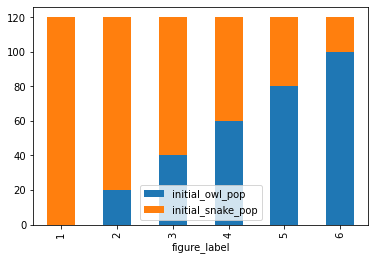

In [3]:
df_owl.set_index('figure_label').plot(kind='bar', stacked=True)

In [13]:
bp_df = result.groupby(['exp_name','org','exp']).agg(
    # Get max of the duration column for each group
    exp_mean_bp=pd.NamedAgg(column='mean_bush_pref', aggfunc='mean'),
    exp_std_bp=pd.NamedAgg(column='mean_bush_pref', aggfunc='std'),
    exp_se_bp=pd.NamedAgg(column='mean_bush_pref', aggfunc='sem')
    )
bp_df = bp_df.reset_index()
bp_df.head()   

,exp_name,org,exp,exp_mean_bp,exp_std_bp,exp_se_bp
0,energy_gain_mixed,krat,experiment1,0.501605,0.022913,0.003240
1,energy_gain_mixed,krat,experiment2,0.496083,0.023798,0.003366
2,energy_gain_mixed,krat,experiment3,0.368180,0.029609,0.004187
3,energy_gain_mixed,krat,experiment4,0.271673,0.016533,0.002338
4,energy_gain_mixed,krat,experiment5,0.233369,0.009154,0.001295


AttributeError: 'FacetGrid' object has no attribute 'set_title'

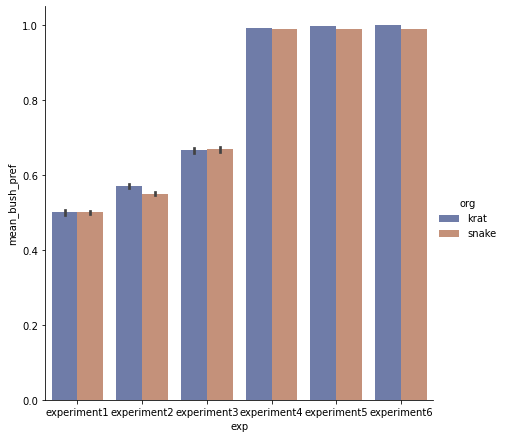

In [3]:
exps = result['exp_name'].unique()
for i in exps:
    temp = temp_data(df=result,filter_val=i)
    ax = sns.catplot(
    data=temp, kind="bar",
    x="exp", y="mean_bush_pref", hue="org",
    ci=95, palette="dark", alpha=.6, height=6
    )
    ax.set_title(i)


In [7]:
# fig, ax = plt.subplots(len(exps), 3)

# for i, title in enumerate(exps):
#     for j in range(3):
#         if j==0:
#             sns.catplot(
#                 ax= ax[i,j],data=temp, kind="bar",
#                 x="exp", y="mean_bush_pref", hue="org",
#                 ci=95, palette="dark", alpha=.6
#                 )
#     ax[i,j].set_title(title)

# fig



In [12]:
#https://stackoverflow.com/questions/44246650/add-image-annotations-to-bar-plots/44264051#44264051
def offset_chart(coord, plt_exp, ax):
    plot = plt_exp
    im = OffsetImage(plot, zoom=0.72)
    im.image.axes = ax

    ab = AnnotationBbox(im, (coord, 0),  xybox=(0., -16.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)

TypeError: Image data of dtype object cannot be converted to float

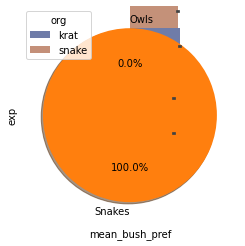

In [13]:
fig, ax = plt.subplots()
temp = temp_data(df=result,filter_val='owl_exp_pure')
g0 = sns.barplot(
        ax=ax, data=temp, 
        x="mean_bush_pref", y="exp", hue="org",
        ci=95, palette="dark", alpha=.6
    )
ax.tick_params(axis='y', which='major', pad=26)

for index, row in df_owl.iterrows():
    data = [row['initial_owl_pop'],row['initial_snake_pop']]
    plot = ax.pie(data, labels=['Owls','Snakes'], autopct='%1.1f%%',
            shadow=True, startangle=90)
    offset_chart(index, plot, ax)

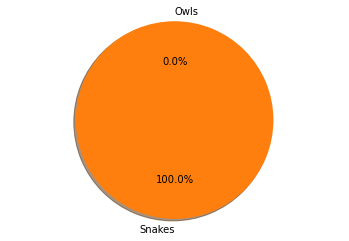

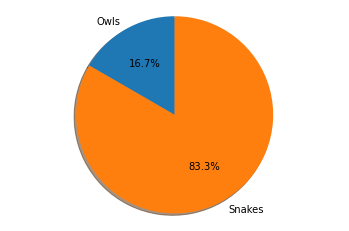

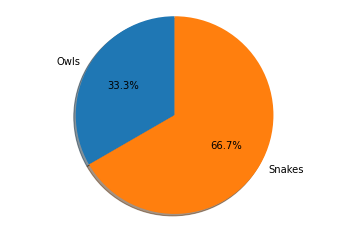

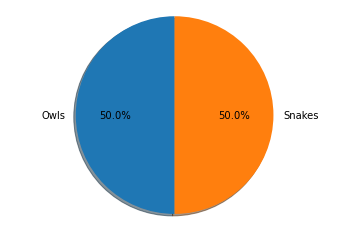

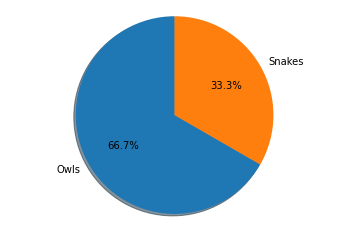

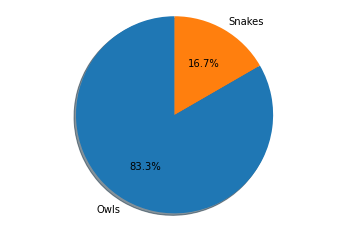

In [12]:
#df_owl.head()

fig, axes = plt.subplots(len(exps), 3, sharex=False,sharey=True, figsize=(36,28))

for i, title in enumerate(exps):
    temp = temp_data(df=result,filter_val=title)
    g0 = sns.barplot(
            ax=axes[i,0], data=temp, 
            x="mean_bush_pref", y="exp", hue="org",
            ci=95, palette="dark", alpha=.6
        ).set(title='{} Mean Bush Preference'.format(title))
    
for index, row in df_owl.iterrows():
    data = [row['initial_owl_pop'],row['initial_snake_pop']]
    fig1, ax1 = plt.subplots()
    ax1.pie(data, labels=['Owls','Snakes'], autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

In [ ]:
# Make Pi Chart
for i, title in enumerate(exps):
    #temp = temp_data(df=result,filter_val=title)
    ##Initial condition figs
    if title in ['owl_exp_pure','owl_exp_mixed']:
        df_owl.set_index('figure_label').plot(ax=axes[i,0],kind='bar', stacked=True).set(
            title='{} \n Initial Conditions'.format(format_title(title)),
              xlabel = "Experimental Group",
              ylabel = "Predators")
    elif title in ['strike_exp_pure','strike_exp_mixed']:
        df_ss.set_index('figure_label').plot(ax=axes[i,0],kind='bar', stacked=True).set(
            title='{} \n Initial Conditions'.format(format_title(title)),
              xlabel = "Experimental Group",
              ylabel = "Strike Success Probability")
    elif title in ['energy_gain_pure','energy_gain_mixed']:
        df_eg.set_index('figure_label').plot(ax=axes[i,0],kind='bar', stacked=True).set(
            title='{} \n Initial Conditions'.format(format_title(title)),
              xlabel = "Experimental Group",
              ylabel = "Energy Gain")
# fig1, ax1 = plt.subplots()
# ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
#         shadow=True, startangle=90)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


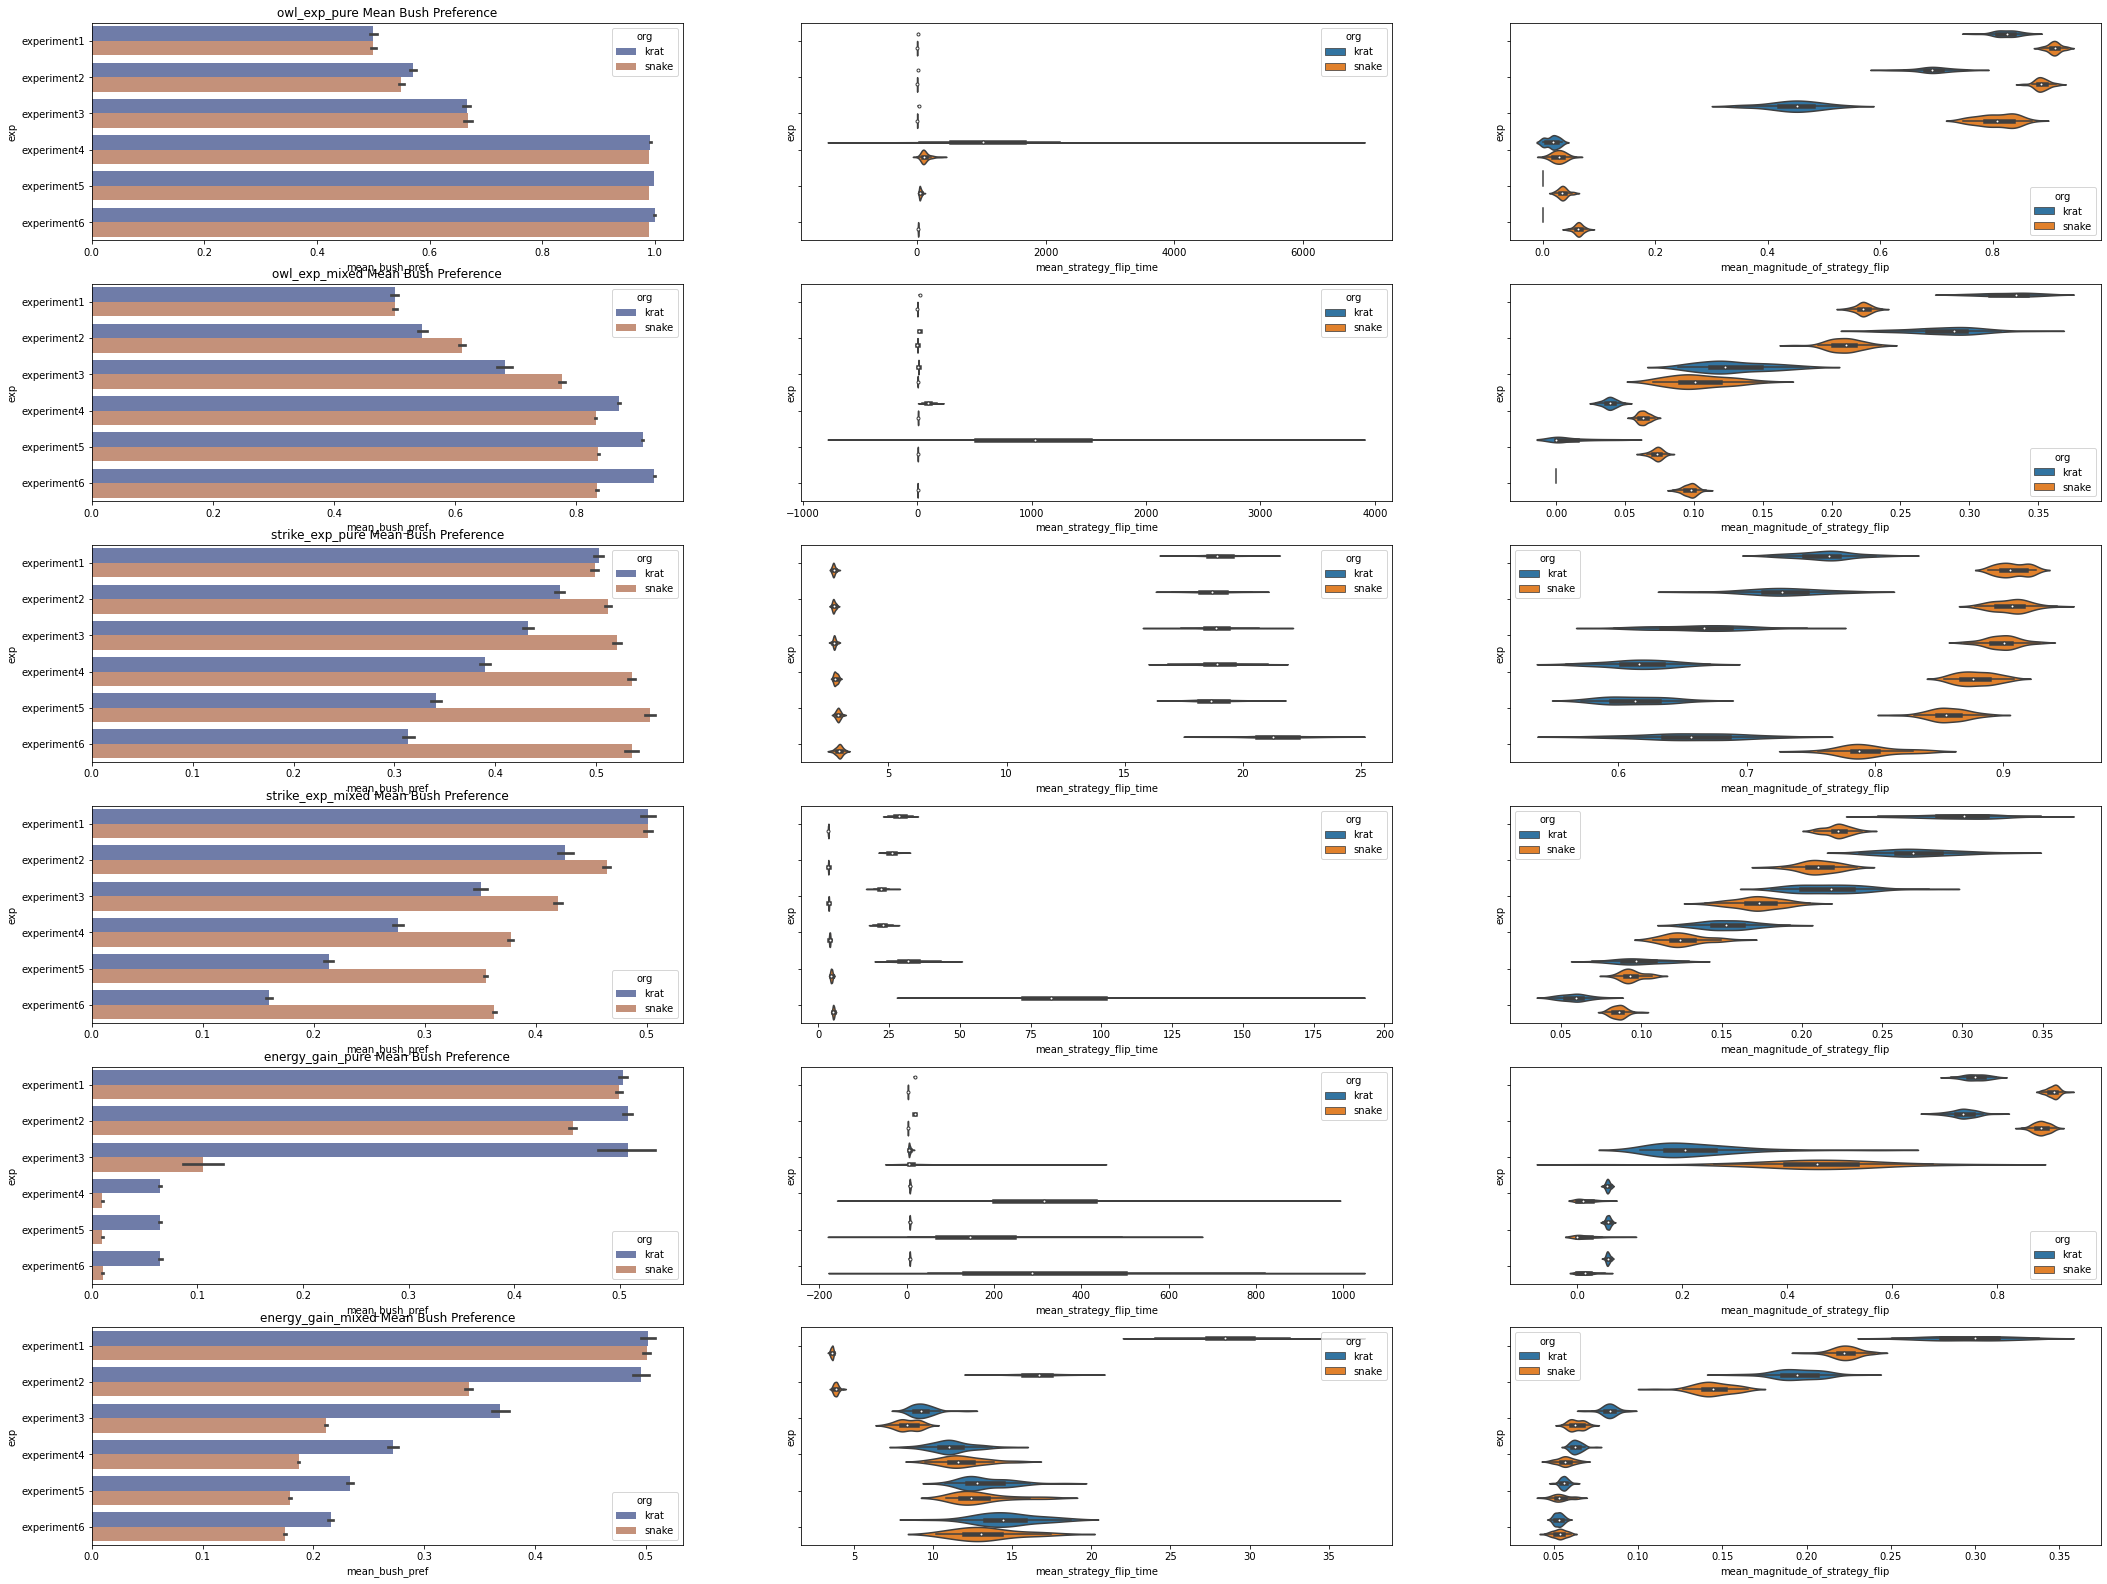

In [6]:
exps = result['exp_name'].unique()
# An lmplot


fig, axes = plt.subplots(len(exps), 3, sharex=False,sharey=True, figsize=(36,28))

for i, title in enumerate(exps):
    temp = temp_data(df=result,filter_val=title)
    g0 = sns.barplot(
            ax=axes[i,0], data=temp, 
            x="mean_bush_pref", y="exp", hue="org",
            ci=95, palette="dark", alpha=.6
        ).set(title='{} Mean Bush Preference'.format(title))
    g1 = sns.violinplot(ax=axes[i,1],x="mean_strategy_flip_time", y="exp",hue="org", data=temp)
    g2 = sns.violinplot(ax=axes[i,2],x="mean_magnitude_of_strategy_flip", y="exp",hue="org", data=temp)

    

# A JointGrid


#gs.update(top=0.7)

plt.show()

In [23]:
#result.head()

,exp_name,sim_id,exp,org,count_str_flip,mean_strategy_flip_time,std_strategy_flip_time,var_strategy_flip_time,mean_magnitude_of_strategy_flip,std_magnitude_of_strategy_flip,var_magnitude_of_strategy_flip,data_type,mean_bush_pref,Figure_Label
0,owl_exp_pure,06028c5bc0bb4674a7d322d9ac32ed5e,experiment1,krat,356,16.833803,12.288573,151.009024,0.843390,0.360106,0.129677,krat,0.514374,1
1,owl_exp_pure,06028c5bc0bb4674a7d322d9ac32ed5e,experiment1,snake,373,2.663978,1.234060,1.522904,0.887674,0.263518,0.069442,snake,0.494487,1
2,owl_exp_pure,078a550708c94ad589f54acb02b8b55a,experiment1,krat,385,15.484375,10.767651,115.942314,0.805410,0.393076,0.154509,krat,0.547678,1
3,owl_exp_pure,078a550708c94ad589f54acb02b8b55a,experiment1,snake,383,2.591623,1.096754,1.202869,0.909786,0.211419,0.044698,snake,0.463121,1
4,owl_exp_pure,0ebf538877ac46fda69541db6a494fa0,experiment1,krat,372,16.123989,10.884938,118.481882,0.852848,0.351398,0.123480,krat,0.504739,1


In [4]:
exps = result['exp_name'].unique()
# An lmplot


# fig, axes = plt.subplots(len(exps), 3, sharex=True,sharey=False, figsize=(18,36))

# for i, title in enumerate(exps):
#     temp = temp_data(df=result,filter_val=title)
#     g0 = sns.barplot(
#             ax=axes[i,0], data=temp, 
#             x='figure_label', y="mean_bush_pref", hue="org",
#             ci=95, palette="dark", alpha=.6
#         ).set(title='{} \n Mean Bush Preference'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Mean Bush Preference",
#               ylim=(0, 1))
#     g1 = sns.violinplot(ax=axes[i,1],x='figure_label', y="mean_strategy_flip_time",hue="org", palette="dark", data=temp).set(title='{} \n Mean Generations Before STR Flip'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Mean Generations Before STR Flip")
#     g2 = sns.violinplot(ax=axes[i,2],x='figure_label', y="mean_magnitude_of_strategy_flip", palette="dark", hue="org", data=temp).set(title='{} \n Mean Magnitude of STR Flip'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Mean Magnitude of STR Flip",
#               ylim=(0, 1))

    

# # A JointGrid


# #gs.update(top=0.7)
# plt.savefig('results.png')
# plt.show()


In [5]:
exps = result['exp_name'].unique()
# An lmplot


# fig, axes = plt.subplots(len(exps), 4, sharex=True,sharey=False, figsize=(24,36))

# for i, title in enumerate(exps):
#     temp = temp_data(df=result,filter_val=title)
#     ##Initial condition figs
#     if title in ['owl_exp_pure','owl_exp_mixed']:
#         df_owl.set_index('figure_label').plot(ax=axes[i,0],kind='bar', stacked=True).set(
#             title='{} \n Initial Conditions'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Predators")
#     elif title in ['strike_exp_pure','strike_exp_mixed']:
#         df_ss.set_index('figure_label').plot(ax=axes[i,0],kind='bar', stacked=True).set(
#             title='{} \n Initial Conditions'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Strike Success Probability")
#     elif title in ['energy_gain_pure','energy_gain_mixed']:
#         df_eg.set_index('figure_label').plot(ax=axes[i,0],kind='bar', stacked=True).set(
#             title='{} \n Initial Conditions'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Energy Gain")
#     ## MHPREF
#     g1 = sns.barplot(
#             ax=axes[i,1], data=temp, 
#             x='figure_label', y="mean_bush_pref", hue="org",
#             ci=95, palette="dark", alpha=.6
#         ).set(title='{} \n Mean Bush Preference'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Mean Bush Preference",
#               ylim=(0, 1))
#     ## Generations
#     g2 = sns.violinplot(ax=axes[i,2],x='figure_label', y="mean_strategy_flip_time",hue="org", palette="dark", data=temp).set(title='{} \n Mean Generations Before STR Flip'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Mean Generations Before STR Flip")
#     #Magnitude
#     g3 = sns.violinplot(ax=axes[i,3],x='figure_label', y="mean_magnitude_of_strategy_flip", palette="dark", hue="org", data=temp).set(title='{} \n Mean Magnitude of STR Flip'.format(format_title(title)),
#               xlabel = "Experimental Group",
#               ylabel = "Mean Magnitude of STR Flip",
#               ylim=(0, 1))

    

# # A JointGrid


# #gs.update(top=0.7)
# #plt.savefig('results_with_ic.png')
# plt.show()


In [6]:
#df_eg.head()

In [1]:
help(sns.plot)

NameError: name 'sns' is not defined